# Housing data extraction and aggregation

This notebook consists of two steps:

1. Extraction of relevant sales price values of homes in the ZTRAX database[<sup>1</sup>](#fn1).
2. Filtering of the data with some QA/QC algorithms and aggregation of the remaining building-level sales prices to an average "price per sq ft." value for each grid cell in our POP sample.

<span id="fn1"> <sup>1</sup>Data provided by Zillow through the Zillow Transaction and Assessment Dataset (ZTRAX). More information on accessing the data can be found athttp://www.zillow.com/ztrax. The results and opinions are those of the author(s) and do not reflect the position of Zillow Group. </span>

## Setup

In [1]:
import os
from datetime import datetime as dt
from glob import glob
from os.path import basename, dirname, isfile, join

import geopandas as gpd
import numpy as np
import pandas as pd
import shapely as shp
import shapely.geometry
import shapely.vectorized
from dask.distributed import Client, LocalCluster, progress
from mosaiks import config as cfg
from mosaiks.utils import io
from scipy.stats.mstats import gmean

app = "housing"
cfg = io.get_filepaths(cfg, app)
chousing = cfg.housing
c_ext = chousing["data"]["ztrax"]
grid_str, _ = io.get_suffix(cfg, app)
grid_path = join(cfg.grid_dir, "grid_" + grid_str + ".npz")
sample_path = join(cfg.grid_dir, "{}.npz".format(cfg.data_suffix))

# location of raw ztrax data
ztrax_dir_raw = join(cfg.data_dir, "raw", "path", "to", "ztrax", "database")

# location of extracted ztrax data from step 1
ztrax_dir_int = join(dirname(cfg.outcomes_fpath), "states")
os.makedirs(ztrax_dir_int, exist_ok=True)

# location of state shapefile
state_path = join(
    cfg.data_dir, "raw", "shapefiles", "USA", "gadm_USA_shp", "gadm_USA_1.shp"
)

# location of the 2 different databases in ZTRAX
zillow_as_path = join(ztrax_dir_raw, "Zillow_Assessor")
zillow_trans_path = join(ztrax_dir_raw, "Zillow_Transaction")

env variable MOSAIKS_HOME not defined; setting to: "/shares/lab/Datasets/Remote_Sensing/replication"
If not desired, please reset os.environ["MOSAIKS_NAME"]


In [2]:
state_codes = {
    "WA": "53",
    "DE": "10",
    "DC": "11",
    "WI": "55",
    "WV": "54",
    "HI": "15",
    "FL": "12",
    "WY": "56",
    "PR": "72",
    "NJ": "34",
    "NM": "35",
    "TX": "48",
    "LA": "22",
    "NC": "37",
    "ND": "38",
    "NE": "31",
    "TN": "47",
    "NY": "36",
    "PA": "42",
    "AK": "02",
    "NV": "32",
    "NH": "33",
    "VA": "51",
    "CO": "08",
    "CA": "06",
    "AL": "01",
    "AR": "05",
    "VT": "50",
    "IL": "17",
    "GA": "13",
    "IN": "18",
    "IA": "19",
    "MA": "25",
    "AZ": "04",
    "ID": "16",
    "CT": "09",
    "ME": "23",
    "MD": "24",
    "OK": "40",
    "OH": "39",
    "UT": "49",
    "MO": "29",
    "MN": "27",
    "MI": "26",
    "RI": "44",
    "KS": "20",
    "MT": "30",
    "MS": "28",
    "SC": "45",
    "KY": "21",
    "OR": "41",
    "SD": "46",
}

Data is extracted by state, and uses the [dask](https://docs.dask.org/en/latest/) package to process each state in parallel if possible. Dask is configurable such that, by default, this code should run on a single shared-memory machine, using as many cores are available. If you are running this on a multi-node cluster, you will need to do some additional setup to configure dask with whatever job scheduler you might have on the cluster.

Here you will want to configure several things relevant to the machine you are working on and instantiate the dask scheduler that will run each process extracting data from the database.
- `chunksize` is the number of rows of each ZTRAZX csv to process. Setting it too high will cause memory issues. Setting it too low will require too much I/O time.
- `cluster_kwargs` consists of any `dask` kwargs you would like to pass to your Cluster instance


In [3]:
chunksize = 1000000
cluster_kwargs = {"n_workers": 1, "threads_per_worker": 4, "memory_limit": "100G"}

cluster = LocalCluster(**cluster_kwargs)
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:44886 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 4 Memory: 100.00 GB


## Housing Price/sq ft. extraction and aggregation

This process occurs in two steps. In the first, we filter to the sales we are interested in, using the following sub-steps:

1. Selecting residential buildings only
2. Selecting only buildings with valid lat/lon coordinates
3. Selecting sales occuring on or after Jan 1 2010
4. Selecting only sales with non-null prices

In the second step, we apply additional QA/QC filters and average cells up to our sampled grid cells, using the following steps:

1. Dropping all sales under \$10k
2. Dropping all buildings under 100 sq ft
3. Dropping all sales under \$10/sq ft
4. By state, dropping all sales above the 99th percentile of remaining sales in that state
5. Keeping the latest sale if multiple sales of a given property remain.
6. Taking the mean of remaining sales within each grid cell for the POP sample

Performing this extraction, QA/QC, and aggregation in two separate steps allows one to test various QA/QC approaches without having to re-extract from the raw Zillow data.

### Load grid, sample, and shapefiles

In [4]:
grid = dict(np.load(grid_path))
sample = dict(np.load(sample_path))

state_gdf = gpd.read_file(state_path)
state_gdf["HASC_1"] = state_gdf.HASC_1.str[-2:]
state_gdf = state_gdf[~state_gdf.HASC_1.isin(["PR", "HI", "AK"])]

## turn lats and lons from full grid into dataframe with lat/lon as index and i/j as value
lons = (
    pd.DataFrame(grid["lon"], columns=["lon"])
    .reset_index()
    .set_index("lon")
    .rename(columns={"index": "j"})
)
lats = (
    pd.DataFrame(grid["lat"], columns=["lat"])
    .reset_index()
    .set_index("lat")
    .rename(columns={"index": "i"})
)

## adjust for 1-indexed i and j
lons += 1
lats += 1

# need to flip lats b/c it's monotonic decreasing
lats = lats.sort_index()

# get list of sampled data points
this_id = sample["ID"].astype(str)
sample_ix = pd.MultiIndex.from_tuples(
    [tuple([int(j) for j in i.split(",")]) for i in this_id]
)

### Extract data

In [5]:
def get_df(func, it, print_progress=False):
    result = []
    for ix, i in enumerate(it):
        if print_progress and (ix % 5 == 0):
            print("Line {}".format(ix))
        this_res = func(i)
        if this_res.shape[0] > 0:
            result.append(this_res)
    result = pd.concat(result)
    return result


def hash_rowid(df, index_cols="rowID"):
    dup_ids = df["rowID"].duplicated(keep=False).sum()
    df["rowID"] = df["rowID"].apply(lambda x: hash(x))

    # check we havent created hash collisions
    assert df["rowID"].duplicated(keep=False).sum() == dup_ids

    df = df.set_index(index_cols, drop=True)
    return df


def get_sampled_val(this_st, this_geom, chunksize=1000000, settings=c_ext):

    # improves performance to not check this
    pd.options.mode.chained_assignment = None

    ## GET RELEVANT FILES AND POINTS
    # find points in this state
    points_in_st = shp.vectorized.contains(this_geom, sample["lon"], sample["lat"])
    this_id = sample["ID"][points_in_st].astype(str)
    this_st_fips = state_codes[this_st]
    trans_trans_main_path = join(zillow_trans_path, this_st_fips, "ZTrans", "Main.txt")
    trans_trans_prop_path = join(
        zillow_trans_path, this_st_fips, "ZTrans", "PropertyInfo.txt"
    )
    trans_asmt_main_path = join(zillow_trans_path, this_st_fips, "ZAsmt", "Main.txt")
    asmt_asmt_main_path = join(zillow_as_path, this_st_fips, "ZAsmt", "Main.txt")
    trans_asmt_bldg_path = join(
        zillow_trans_path, this_st_fips, "ZAsmt", "Building.txt"
    )
    asmt_asmt_bldg_path = join(zillow_as_path, this_st_fips, "ZAsmt", "Building.txt")
    trans_asmt_bldgArea_path = join(
        zillow_trans_path, this_st_fips, "ZAsmt", "BuildingAreas.txt"
    )
    asmt_asmt_bldgArea_path = join(
        zillow_as_path, this_st_fips, "ZAsmt", "BuildingAreas.txt"
    )
    out_path = join(ztrax_dir_int, "outcomes_all_{}_{}.pickle".format(app, this_st))
    out_path_agg = out_path.replace(".pickle", "_aggregated.pickle")

    if isfile(out_path_agg):
        return pd.read_pickle(out_path_agg)

    ## ##################
    ## TRANSACTION/ZTRANS
    ## ##################
    print("Loading trans/trans/main", this_st)
    ## Main
    it = pd.read_csv(
        trans_trans_main_path,
        delimiter="|",
        usecols=[0, 6, 24, 25, 30],
        names=["rowID", "date", "price", "sale_code", "if_xfer"],
        index_col=0,
        chunksize=chunksize,
        dtype={
            "rowID": int,
            "price": float,
            "sale_code": str,
            "if_xfer": str,
            "date": str,
        },
        quoting=3,
    )

    def get_trans_trans_main(trans_info):
        # drop missing dates, 0-priced sales, and intra-family transfers
        trans_info = trans_info[
            (trans_info["date"] != "")
            & (trans_info["date"].notnull())
            & (trans_info["price"] > 0)
            & (trans_info["if_xfer"] != "Y")
        ]
        trans_info["date"] = pd.to_datetime(
            trans_info["date"], format="%Y-%m-%d", errors="coerce"
        )

        # keep only sales after date
        trans_info = trans_info[
            trans_info.date
            > pd.to_datetime("{}-01-01".format(settings["cutoff_yr"]), errors="coerce")
        ]

        # drop if_xfer column
        trans_info = trans_info.drop(columns="if_xfer")
        return trans_info

    trans_trans_main = get_df(get_trans_trans_main, it)

    print("Loading trans/trans/propertyInfo", this_st)
    ## Prop
    it = pd.read_csv(
        trans_trans_prop_path,
        delimiter="|",
        usecols=[0, 52, 53, 64],
        names=["rowID", "lat", "lon", "parcelID"],
        index_col=0,
        dtype={"rowID": int, "lat": str, "lon": str, "parcelID": str},
        chunksize=chunksize,
        quoting=3,
    )

    def get_trans_trans_prop(prop_info):
        prop_info[["lon", "lat"]] = prop_info[["lon", "lat"]].apply(
            pd.to_numeric, errors="coerce"
        )
        return prop_info.dropna(how="all")

    trans_trans_prop = get_df(get_trans_trans_prop, it)

    ## Merge prop and main
    merged = trans_trans_main.join(trans_trans_prop, how="left")
    del trans_trans_main, trans_trans_prop

    ## Keep only if it has parcel ID in order
    # to match to land use code
    merged = merged.dropna(subset=["parcelID"])

    ## set index to parcelID b/c no longer need rowID
    merged = merged.set_index("parcelID", drop=True)

    ## ##################
    ## TRANSACTION/ZASMT
    ## ##################

    ## Main
    print("Loading trans/asmt/main", this_st)
    it = pd.read_csv(
        trans_asmt_main_path,
        delimiter="|",
        usecols=[0, 1, 81, 82],
        names=["rowID", "parcelID", "lat_asmt", "lon_asmt"],
        quoting=3,
        dtype={"rowID": str, "parcelID": str, "lat_asmt": str, "lon_asmt": str},
        chunksize=chunksize,
    )

    def get_asmt_main(asmt_info):
        asmt_info = hash_rowid(asmt_info)
        asmt_info[["lon_asmt", "lat_asmt"]] = asmt_info[["lon_asmt", "lat_asmt"]].apply(
            pd.to_numeric, errors="coerce"
        )
        return asmt_info

    trans_asmt_main = get_df(get_asmt_main, it)

    ## Building
    print("Loading trans/asmt/building", this_st)
    it = pd.read_csv(
        trans_asmt_bldg_path,
        delimiter="|",
        usecols=[0, 5],
        names=["rowID", "landuse"],
        quoting=3,
        infer_datetime_format=True,
        dtype={"rowID": str, "landuse": str},
        chunksize=chunksize,
    )

    def get_asmt_bldg(bldg_info):
        bldg_info = hash_rowid(bldg_info)
        bldg_info = bldg_info.dropna()
        bldg_info.landuse = bldg_info.landuse.apply(lambda x: x[:2])
        bldg_info = bldg_info[
            (bldg_info.landuse.isin(settings["use_codes_include"]))
            & ~(bldg_info.landuse.isin(settings["use_codes_not_include"]))
        ]
        return bldg_info

    trans_asmt_bldg = get_df(get_asmt_bldg, it)
    res_bldgs = trans_asmt_bldg.index

    ## Reindex main to only have residential buildings
    trans_asmt_main = trans_asmt_main.reindex(res_bldgs).dropna(subset=["parcelID"])

    ## Building Area
    print("Loading trans/asmt/buildingArea", this_st)
    it = pd.read_csv(
        trans_asmt_bldgArea_path,
        delimiter="|",
        usecols=[0, 1, 4],
        names=["rowID", "imp", "sqft"],
        dtype={"rowID": str, "imp": int, "sqft": float},
        chunksize=chunksize,
        quoting=3,
    )

    def get_asmt_bldgArea(asmt_bldgArea):
        asmt_bldgArea = hash_rowid(asmt_bldgArea, index_cols=["rowID", "imp"])
        # take whatever is the largest building area code as measure of sqfootage
        asmt_bldgArea = asmt_bldgArea.groupby(level=[0, 1]).max()

        # sum over multiple improvements on land
        asmt_bldgArea = asmt_bldgArea.groupby(level=0).sum()

        return asmt_bldgArea

    trans_asmt_bldgArea = get_df(get_asmt_bldgArea, it)

    # Merge sqft data into main
    trans_asmt_main = trans_asmt_main.join(trans_asmt_bldgArea, how="left")

    ## Set index to parcelID
    trans_asmt_main = trans_asmt_main.set_index("parcelID", drop=True)

    ## Inner merge with trans/trans to get properties with price data
    # and residential classification
    merged_trans = merged.join(trans_asmt_main, how="inner")
    del trans_asmt_main, trans_asmt_bldg, trans_asmt_bldgArea, res_bldgs

    # fill in lat/lon from trans/asmt/main data
    for l in ["lat", "lon"]:
        merged_trans[l] = merged_trans[l].fillna(merged_trans[l + "_asmt"])
        del merged_trans[l + "_asmt"]

    ## ##################
    ## ASSESSOR/ZASMT
    ## ##################

    ## Main
    print("Loading asessor/asmt/main", this_st)
    it = pd.read_csv(
        asmt_asmt_main_path,
        delimiter="|",
        usecols=[0, 1, 6, 81, 82],
        names=["rowID", "parcelID", "extract_date", "lat_asmt", "lon_asmt"],
        quoting=3,
        chunksize=chunksize,
        dtype={
            "rowID": str,
            "parcelID": str,
            "extract_date": str,
            "lat_asmt": str,
            "lon_asmt": str,
        },
    )

    def get_asmt_asmt_main(asmt2_info):
        asmt2_info = hash_rowid(asmt2_info)
        asmt2_info[["lat_asmt", "lon_asmt"]] = asmt2_info[
            ["lat_asmt", "lon_asmt"]
        ].apply(pd.to_numeric, errors="coerce")
        asmt2_info["extract_date"] = pd.to_datetime(
            asmt2_info["extract_date"], format="%m%Y", errors="coerce"
        )

        # drop if rowID, parcelID or lat/lon missing
        asmt2_info = asmt2_info[
            (asmt2_info.index.notnull())
            & (asmt2_info[["lat_asmt", "lon_asmt", "parcelID"]].notnull().all(axis=1))
        ]
        return asmt2_info

    asmt_asmt_main = get_df(get_asmt_asmt_main, it, print_progress=True)
    print("Completed asessor/asmt/main", this_st)

    ## Building
    print("Loading asessor/asmt/building", this_st)
    it = pd.read_csv(
        asmt_asmt_bldg_path,
        delimiter="|",
        usecols=[0, 5],
        names=["rowID", "landuse"],
        quoting=3,
        infer_datetime_format=True,
        dtype={"rowID": str, "landuse": str},
        chunksize=chunksize,
    )
    asmt_asmt_bldg = get_df(get_asmt_bldg, it)
    res_bldgs_asmt = asmt_asmt_bldg.index

    # Reindex main to only have residential buildings
    asmt_asmt_main = asmt_asmt_main.reindex(res_bldgs_asmt).dropna()

    # Take only the latest extraction date by parcel ID
    # (theoretically most up-to-date location)
    # IB 1/23/19: More thorough approach would be to match to sales
    # first and THEN take extraction date closest to sale date
    asmt_asmt_main = (
        asmt_asmt_main.sort_values("extract_date")
        .reset_index(drop=False)
        .groupby("parcelID")
        .last()
        .reset_index(drop=False)
        .set_index("rowID", drop=True)
    )

    ## Building Area
    print("Loading asessor/asmt/buildingArea", this_st)
    it = pd.read_csv(
        asmt_asmt_bldgArea_path,
        delimiter="|",
        usecols=[0, 1, 4],
        names=["rowID", "imp", "sqft"],
        dtype={"rowID": str, "imp": int, "sqft": float},
        chunksize=chunksize,
        quoting=3,
    )
    asmt_asmt_bldgArea = get_df(get_asmt_bldgArea, it)

    # Merge sqft data into main
    asmt_asmt_main = asmt_asmt_main.join(asmt_asmt_bldgArea, how="left").set_index(
        "parcelID", drop=True
    )

    ## Inner merge with trans/trans to get properties with price data
    # and residential classification
    merged_asmt = merged.join(asmt_asmt_main, how="inner")
    del asmt_asmt_main, asmt_asmt_bldg, res_bldgs_asmt, asmt_asmt_bldgArea

    # fill in lat/lon from trans/asmt/main data
    for l in ["lat", "lon"]:
        merged_asmt[l] = merged_asmt[l].fillna(merged_asmt[l + "_asmt"])
        del merged_asmt[l + "_asmt"]

    ## ##################
    ## COMBINE ALL FILES
    ## ##################
    merged_all = merged_trans.join(merged_asmt, how="outer", rsuffix="_asmt")
    del merged_trans, merged_asmt

    # merge data from asmt/asmt and trans/asmt
    cols = ["date", "price", "sale_code", "lat", "lon", "sqft"]
    cols_asmt = [c + "_asmt" for c in cols]
    change_dict = dict([(cols_asmt[cx], c) for cx, c in enumerate(cols)])
    merged_all = merged_all.loc[:, cols].fillna(
        merged_all.loc[:, cols_asmt].rename(columns=change_dict)
    )

    # drop any missing that remained
    merged_all = merged_all.dropna(subset=["price", "lat", "lon"])

    # get column for price only if sqft is not null
    merged_all["price_hasSize"] = merged_all["price"].where(
        merged_all["sqft"].notnull()
    )

    # add state column and drop unneeded sale code
    merged_all["state"] = this_st
    merged_all = merged_all.drop(columns=["sale_code"])

    ## aggregating ##
    merged_all = merged_all.sort_values(by="lon")
    merged_all["j"] = pd.merge_asof(
        merged_all[["lon"]], lons, left_on="lon", direction="nearest", right_index=True
    ).loc[:, "j"]

    merged_all = merged_all.sort_values(by="lat")
    merged_all["i"] = pd.merge_asof(
        merged_all[["lat"]], lats, left_on="lat", direction="nearest", right_index=True
    ).loc[:, "i"]

    # save merged but not aggregated/sampled data
    merged_all.to_pickle(out_path)

    ## ##################
    ## QA/QC + Aggregation
    ## ##################

    price_cols = ["price", "price_per_sqft"]

    ### QA/QC
    # Drop if <= $10k
    merged_all = merged_all[merged_all["price"] > 10000]

    # drop price/sqft if sqft <= 100
    merged_all["sqft"] = merged_all["sqft"].where(merged_all["sqft"] > 100)
    merged_all["price_per_sqft"] = merged_all["price_hasSize"] / merged_all["sqft"]

    # drop price/sqft if price/sqft <= $10
    merged_all["price_per_sqft"] = merged_all["price_per_sqft"].where(
        merged_all["price_per_sqft"] > 10
    )

    # Drop obs over Kth percentile by state
    tile = cfg.housing["data"]["ztrax"]["pctile_clip"]
    maxs = merged_all[price_cols].quantile(tile)
    merged_all.loc[:, price_cols] = merged_all.loc[:, price_cols].where(
        merged_all.loc[:, price_cols] <= maxs
    )
    merged_all = merged_all.dropna(subset=price_cols, how="all")

    # Keep only latest sale
    merged_all = merged_all.sort_values(by="date")
    merged_all = merged_all[~merged_all.index.duplicated(keep="last")]

    ### Aggregate over images
    # Keep just the columns you need
    merged_all = merged_all.drop(columns=["date", "sqft", "price_hasSize", "state"])

    ## aggregating ##
    grouped = merged_all[price_cols + ["i", "j"]].groupby(["i", "j"])

    # collapse to grid cell using mean and geometric mean
    agg_val = grouped.mean()
    agg_val.columns = price_cols
    agg_val_geom = grouped.agg(lambda x: gmean(x.dropna()))
    agg_val_geom.columns = [p + "_geomMean" for p in price_cols]
    agg_count = grouped.count()
    count_cols = ["n_obs_" + p for p in price_cols]
    agg_count.columns = count_cols
    out_all = pd.concat([agg_val, agg_val_geom, agg_count], axis=1)

    # take just sample cells (sample_ix has sampled id's)
    out_df = out_all.reindex(index=sample_ix)
    out_df = out_df.dropna(subset=price_cols, how="all")

    # If the number of obs col is missing, there are no houses in that image tile
    out_df.loc[:, count_cols] = out_df.loc[:, count_cols].fillna(0)

    # combine multiindex
    out_df.index = (
        out_df.index.get_level_values(0).astype(str)
        + ","
        + out_df.index.get_level_values(1).astype(str)
    )
    out_df.index.name = "ID"

    for col in count_cols:
        out_df[col] = out_df[col].astype(int)

    # save version with just clipped values
    out_df.to_pickle(out_path.replace(".pickle", "_aggregated.pickle"))

    return out_df

In [6]:
ftrs = client.map(
    get_sampled_val,
    state_gdf.HASC_1.values,
    state_gdf.geometry.values,
    chunksize=chunksize,
)
progress(ftrs)

VBox()

In [ ]:
data_df = pd.concat(client.gather(ftrs))
cluster.close()
client.close()

In [12]:
# Deal with grid cells that overlapped states
data_df.loc[:, ["price", "price_per_sqft"]] = (
    data_df.loc[:, ["price", "price_per_sqft"]]
    * data_df.loc[:, ["n_obs_price", "n_obs_price_per_sqft"]].values
)
data_df.loc[:, ["price_geomMean", "price_per_sqft_geomMean"]] = (
    np.log(data_df.loc[:, ["price_geomMean", "price_per_sqft_geomMean"]])
    * data_df.loc[:, ["n_obs_price", "n_obs_price_per_sqft"]].values
)
data_df = data_df.groupby(level=0).sum()
data_df.loc[:, ["price", "price_per_sqft"]] = (
    data_df.loc[:, ["price", "price_per_sqft"]]
    / data_df.loc[:, ["n_obs_price", "n_obs_price_per_sqft"]].values
)
data_df.loc[:, ["price_geomMean", "price_per_sqft_geomMean"]] = np.exp(
    data_df.loc[:, ["price_geomMean", "price_per_sqft_geomMean"]]
    / data_df.loc[:, ["n_obs_price", "n_obs_price_per_sqft"]].values
)

In [14]:
# save
data_df.to_csv(cfg.outcomes_fpath, index=True)

### Coverage stats

In [17]:
# Give a sense of coverage
total = data_df.shape[0]
coverage_price = data_df.count()["price"] / total
coverage_sqft = data_df.count()["price_per_sqft"] / total

print(total, coverage_price, coverage_sqft)

86243 0.999315886506731 0.9324814767575339


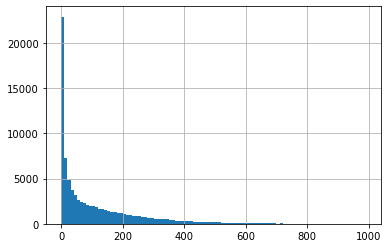

In [20]:
data_df.n_obs_price_per_sqft.hist(bins=range(0, 1000, 10))